In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import lightgbm
from scipy.stats import mstats
from typing import Literal
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from category_encoders import OrdinalEncoder
from datetime import datetime
from pycaret.internal.preprocess.transformers import TransformerWrapper, ExtractDateTimeFeatures
from mlxtend.feature_selection import ColumnSelector
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from pycaret.regression import *
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
unseen = pd.read_csv('../data/data_daegu_apartment_preparation_unseen.csv')
seen = pd.read_csv('../data/data_daegu_apartment_preparation_seen.csv')

# **Data Preparation**

What Will Be Use In Pipeline:<br>

| Technique | Action |
| ----------------------------- | ----------- |
| Handling Outlier | Impute Outlier With Winsorize data That has outlier For Column "Size(sqf)". |
| Min Max Scaling | Transform Numeric Features Such As **'N_Parkinglot(Basement)', 'N_FacilitiesInApt', 'Size(sqf)'** Into Scale Based On Mean On That Data.|
| One Hot Encoding | Transform **'SubwayStation'** using techniques such as one-hot encoding or label encoding. |
| Ordinal Encoding | Transform **'TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(Universities)', 'N_FacilitiesNearBy(PublicOffice)'** using techniques such as ordinal encoding. The Features Has Defisit Correlation From What its supposed to so i need to mapping it manually. |
| Age of the Property | Calculate the age of the property from the **'YearBuilt'** feature to capture the effect of depreciation or appreciation over time.|
| Binning | Transform continuous numerical features such as **'AgeProperty'** into categorical variables where **AgeProperty** Binned into 3,2,1 Value|

In [3]:
# Define the features and target variable
features = seen.drop('SalePrice', axis=1)
target = seen['SalePrice']

# Define the features for each encoding type
min_max_features = ['N_Parkinglot(Basement)', 'N_FacilitiesInApt', 'Size(sqf)']
categorical_features_onehot = ['SubwayStation']
ordinal_features = ['TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(PublicOffice)', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(University)']
outlier_features = ['Size(sqf)']
facilities_features = ['N_FacilitiesNearBy(PublicOffice)', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(University)']
columns_to_drop = ['remainder__Size(sqf)_bins', 'remainder__N_FacilitiesInApt_bins', 
                   'remainder__N_FacilitiesNearBy(PublicOffice)_bins', 
                   'remainder__N_SchoolNearBy(University)_bins']

Definisikan Variable Yang Berisi List Fitur Masing Masing Transformasi Yang Akan Dilakukan Pada Pipeline.

In [4]:
# import winsorize
from scipy.stats.mstats import winsorize

class HandleOutlier(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['Size(sqf)'] = winsorize(X['Size(sqf)'], limits=(0.01, 0.01))
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Code di atas adalah implementasi dari sebuah kelas yang disebut HandleOutlier dalam bahasa pemrograman Python, yang dirancang untuk menangani outlier pada data menggunakan teknik winsorizing. Winsorizing adalah suatu metode untuk mengatasi outlier dengan memotong atau menggantikan nilai-nilai ekstrem dengan nilai batas yang lebih rendah atau lebih tinggi (biasanya disebut sebagai nilai ambang bawah dan ambang atas).

In [5]:
class AgeBinner(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['Binned_AgeProperty'] = pd.cut(X['AgeProperty'], bins=[0, 20, 35, 50], labels=[3, 2, 1])
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Kode di atas mendefinisikan sebuah kelas yang disebut AgeBinner yang bertujuan untuk mengubah kolom 'AgeProperty' dalam dataframe X menjadi kolom baru 'Binned_AgeProperty', di mana nilai-nilai dalam kolom tersebut dikelompokkan ke dalam kategori berdasarkan interval tertentu.

In [6]:
class AgeTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['AgeProperty'] = 2016 - X['YearBuilt']
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Kode di atas mendefinisikan kelas AgeTransformer, yang bertujuan untuk mengubah nilai dalam kolom 'YearBuilt' dari dataframe X menjadi kolom baru 'AgeProperty'. Kolom baru ini menunjukkan usia properti berdasarkan perhitungan tahun saat transformasi dilakukan (2016 - YearBuilt).

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

Code yang diberikan mendefinisikan kelas ColumnDropper yang berfungsi sebagai transformer dalam pipa pemrosesan data. Tujuan utama dari kelas ini adalah untuk menghapus kolom-kolom tertentu dari dataframe.

In [8]:
# Create transformers for each encoding type
min_max_transformer = MinMaxScaler(feature_range=(0, 1))

Di sini, MinMaxScaler dibuat untuk menskalakan fitur numerik dalam rentang 0 hingga 1. Hal ini umum dilakukan untuk memastikan bahwa semua fitur numerik memberikan kontribusi yang sama terhadap model dan mencegah fitur tertentu mendominasi karena skala yang besar.

In [9]:
# Create OneHotEncoder for categorical features
categorical_transformer_onehot = OneHotEncoder(sparse=False)

Untuk fitur kategorikal, dibuat OneHotEncoder. One-hot encoding digunakan untuk merepresentasikan variabel kategorikal sebagai vektor biner, di mana setiap kategori dipetakan ke nilai biner.

In [10]:
mappings = [
    {'col': 'TimeToSubway',
    'mapping': {
        'no_bus_stop_nearby': 0, 
        '0-5min': 4, 
        '5min~10min': 2, 
        '10min~15min': 2,
        '15min~20min': 1,
        }
    },
    {'col': 'HallwayType',
    'mapping': {
        'terraced': 3, 
        'mixed': 2, 
        'corridor': 1, 
        }
    },
    {'col': 'N_FacilitiesNearBy(PublicOffice)',
    'mapping': {
        0 : 4, 
        1 : 3, 
        2 : 2,
        5 : 1, 
        }
    },
    {'col': 'N_SchoolNearBy(University)',
    'mapping': {
        0 : 6, 
        1 : 5, 
        2 : 4,
        3 : 3,
        4 : 2,
        5 : 1, 
        }
    },
    {'col': 'N_FacilitiesNearBy(ETC)',
    'mapping': {
        0 : 4, 
        1 : 3, 
        2 : 2,
        5 : 1, 
        }
    },
]

ordinal_transformer = OrdinalEncoder(mapping=mappings)

Sebuah ordinal encoder dibuat dengan pemetaan kustom untuk kolom-kolom tertentu. Ordinal encoding digunakan ketika terdapat urutan bermakna di antara kategori-kategori tersebut. Pemetaan yang diberikan menentukan pemetaan kategori ke nilai numerik untuk kolom-kolom tertentu seperti 'TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)', dan 'N_FacilitiesNearBy(ETC)'.

Sebagai contoh, pada kolom 'TimeToSubway', kategori 'no_bus_stop_nearby', '0-5min', '5min~10min', dll., dipetakan ke nilai numerik 0, 5, 4, 3, 2, secara berturut-turut.

In [11]:
# Create a column transformer to apply different transformers to different columns
preprocessor = [
    # Handle Outlier
    ('Outlier', TransformerWrapper(
        include=outlier_features,
        transformer=HandleOutlier())),

    # Create New Features Age
    ('Age', TransformerWrapper(
        include=['YearBuilt'],
        transformer=AgeTransformer())),
    
    # Binning Features Size(sqf) and SalePrice
    ('Binnning', TransformerWrapper(
        include=['AgeProperty'],
        transformer=AgeBinner())),
    
    # Transform Some Data
    ('Transform', ColumnTransformer(
    transformers=[
        ('minmax', min_max_transformer, min_max_features),
        ('onehot', categorical_transformer_onehot, categorical_features_onehot),
        ('ordinal', ordinal_transformer, ordinal_features),
    ], remainder='passthrough').set_output(transform='pandas')),

    # # Drop Columns
    # ('Drop', ColumnDropper(columns_to_drop)),
]

# Make a preprocessor pipeline
pipeline = Pipeline(steps=preprocessor)
pipeline

Pipeline(steps=[('Outlier',
                 TransformerWrapper(include=['Size(sqf)'],
                                    transformer=HandleOutlier())),
                ('Age',
                 TransformerWrapper(include=['YearBuilt'],
                                    transformer=AgeTransformer())),
                ('Binnning',
                 TransformerWrapper(include=['AgeProperty'],
                                    transformer=AgeBinner())),
                ('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(...
                                                                           'data_type': dtype('int64'),
                                                                           'mapping': 0    4
1    3
2    2
5    1
dtype: int64},
                                                                          {'col': 'N_SchoolNearBy(University)',
                                                                           'data_type': dtype('int64'),
                                                                           'mapping': 0    6
1    5
2    4
3    3
4    2
5    1
dtype: int64},
                                                                          {'col': 'N_FacilitiesNearBy(ETC)',
                                                                           'data_type': dtype('int64'),
                                                                           'mapping': 0    4
1    3
2    2
5    1
dtype: int64}]),
                                                  ['TimeToSubway',
                                                   'HallwayType',
                                                   'N_FacilitiesNearBy(PublicOffice)',
                                                   'N_FacilitiesNearBy(ETC)',
                                                   'N_SchoolNearBy(University)'])]))])

Keseluruhan Hasil Kelas Yang Sudah Didefinisikan Dimasukkan Ke Dalam Sebuah Pipeline. Pipeline Ini Akan Digunakan Untuk Memproses Data Sebelum Data Masuk Ke Dalam Model. Pipeline Ini Akan Mengikuti Urutan Seperti Di Atas.

In [12]:
pd.set_option('display.max_columns', None)

all_seen = pipeline.fit_transform(features, target)
print(len(all_seen.columns))
all_seen.columns

19


Index(['minmax__N_Parkinglot(Basement)', 'minmax__N_FacilitiesInApt',
       'minmax__Size(sqf)', 'onehot__SubwayStation_Bangoge',
       'onehot__SubwayStation_Banwoldang',
       'onehot__SubwayStation_Chil-sung-market', 'onehot__SubwayStation_Daegu',
       'onehot__SubwayStation_Kyungbuk_uni_hospital',
       'onehot__SubwayStation_Myung-duk', 'onehot__SubwayStation_Sin-nam',
       'onehot__SubwayStation_no_subway_nearby', 'ordinal__TimeToSubway',
       'ordinal__HallwayType', 'ordinal__N_FacilitiesNearBy(PublicOffice)',
       'ordinal__N_FacilitiesNearBy(ETC)',
       'ordinal__N_SchoolNearBy(University)', 'remainder__YearBuilt',
       'remainder__AgeProperty', 'remainder__Binned_AgeProperty'],
      dtype='object')

Berikut Ini Adalah Hasil Data Setelah Melalui Proses Feature Engineering Melalui Pipeline.

# **Benchmark Model**
### Compare From Overall Regressor Model With Pycaret

In [13]:
# Inisialisasi lingkungan pycaret dengan dataset yang telah diproses dan variabel target
exp_reg = setup(data=seen, target='SalePrice', preprocess=False, custom_pipeline=pipeline, 
                use_gpu = False)

,Description,Value
0,Session id,7152
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(2090, 11)"
4,Transformed data shape,"(2090, 20)"
5,Transformed train set shape,"(1463, 20)"
6,Transformed test set shape,"(627, 20)"
7,Numeric features,7
8,Categorical features,3


In [14]:
top_model = compare_models(n_select=5)
top_model

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:44:26
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,38513.6723,2266896314.6325,47475.0130,0.7790,0.2337,0.1987,0.0540
et,Extra Trees Regressor,38524.7982,2291241878.6419,47735.5796,0.7769,0.2350,0.1976,0.0830
lightgbm,Light Gradient Boosting Machine,38602.5616,2297847303.8363,47781.2684,0.7762,0.2348,0.1983,0.2390
rf,Random Forest Regressor,38564.2243,2313219535.7089,47940.4223,0.7745,0.2352,0.1981,0.0950
dt,Decision Tree Regressor,38620.7665,2345106280.3495,48226.1198,0.7712,0.2365,0.1991,0.0360
knn,K Neighbors Regressor,40429.6818,2525433079.4792,50153.0615,0.7548,0.2454,0.2063,0.0720
ada,AdaBoost Regressor,44119.6738,2731278474.9560,52183.2365,0.7336,0.2713,0.2453,0.0460
ridge,Ridge Regression,42992.9830,2840151160.4431,53238.0605,0.7225,0.2558,0.2182,0.0230
br,Bayesian Ridge,42984.5605,2840790479.1484,53242.7175,0.7223,0.2559,0.2180,0.0240
lasso,Lasso Regression,42970.0697,2842838048.6043,53259.6013,0.7220,0.2562,0.2177,0.3120


[GradientBoostingRegressor(random_state=7152),
 ExtraTreesRegressor(n_jobs=-1, random_state=7152),
 LGBMRegressor(random_state=7152),
 RandomForestRegressor(n_jobs=-1, random_state=7152),
 DecisionTreeRegressor(random_state=7152)]

Komparasi Model Dengan Pycaret Default Dengan Resampling 10 Fold Cross Validation <br>

Beberapa model regresi telah dibandingkan menggunakan berbagai metrik performa seperti MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), R² (R-squared), RMSLE (Root Mean Squared Logarithmic Error), MAPE (Mean Absolute Percentage Error), dan waktu pelatihan (TT).

Saya Pilih Top 5 Model Untuk Pengecekan Lebih Lanjut Yaitu:
- Gradient Boosting Regressor   (Ensemble Model)
- Decision Tree Regressor       (Base Model)
- LGBM Regressor                (Ensemble Model)
- Random Forest Regressor       (Ensemble Model)
- Extra Trees Regressor         (Ensemble Model)

Karena Top 5 ini yang sering muncul pada compare_models di pycaret 5 besar meskipun posisinya berubah ubah

In [15]:
# # For Pycaret Bug Analysis
# create_model('xgboost')

### Hyperparameter Tuning

Berdasarkan Hasil Benchmark Model, Untuk Resampling 10 Fold Cross Validation Model Berjalan Lebih Baik Dibandingkan Tanpa Resampling. Oleh Karena Itu, Saya Akan Melakukan Hyperparameter Tuning Pada Model Dengan Resampling 10 Fold Cross Validation.

In [16]:
from numpy import linspace

hyperparam_gbr = {
    'n_estimators': [275, 300, 325],
    'learning_rate': [0.1, 0.105, 0.11],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4]
}   

tuned_gbr = tune_model(
                        estimator=create_model('gbr'),
                        custom_grid=hyperparam_gbr,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40696.9803,2410460419.8955,49096.4400,0.7678,0.2377,0.2029
1,40683.0039,2402158379.7761,49011.8188,0.7804,0.2226,0.1949
2,39498.1177,2392520530.1060,48913.3983,0.7548,0.2252,0.1933
3,40029.1374,2864716018.8451,53523.0419,0.6991,0.2916,0.2394
4,37319.8365,1977044021.0382,44463.9632,0.8140,0.2247,0.1965
5,35842.4626,1936263376.2868,44002.9928,0.7649,0.2292,0.1938
6,33162.6064,1720609524.0786,41480.2305,0.8431,0.2082,0.1709
7,42130.1782,2746379926.7431,52405.9150,0.7492,0.2342,0.1995
8,38220.8948,2069067773.9958,45487.0067,0.7896,0.2274,0.1945


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ini Hasil Tune Model Dengan Resampling 10 Fold Cross Validation Dengan Menggunakan Pycaret Sesuai Parameter Yang Sudah Ditentukan Pada Gradient Bossting Regressor.

In [17]:
hyperparam_dt = {
    'max_depth': [8, 9, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_dt = tune_model(
                        estimator=create_model('dt'),
                        custom_grid=hyperparam_dt,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40095.9759,2369777461.0789,48680.3601,0.7717,0.2354,0.1990
1,40222.6103,2424821827.3714,49242.4799,0.7783,0.2208,0.1904
2,39708.4972,2515678877.2204,50156.5437,0.7422,0.2316,0.1948
3,40555.6143,3253585103.7836,57040.2060,0.6583,0.3022,0.2477
4,38312.1690,2050544991.3306,45282.9437,0.8071,0.2307,0.2029
5,35596.7901,1900117794.4032,43590.3406,0.7693,0.2284,0.1919
6,33023.1204,1770541067.0716,42077.7978,0.8385,0.2086,0.1683
7,43727.3219,2917552909.1684,54014.3769,0.7335,0.2384,0.2040
8,38148.6860,2093541727.5959,45755.2372,0.7871,0.2294,0.1931


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ini Hasil Tune Model Dengan Resampling 10 Fold Cross Validation Dengan Menggunakan Pycaret Sesuai Parameter Yang Sudah Ditentukan Pada Decision Tree Regressor.

In [18]:
hyperparam_rf = {
    'n_estimators': linspace(50, 300, 10, dtype=int),
    'max_depth': linspace(1, 32, 32, dtype=int),
    'min_samples_split': linspace(2, 10, 9, dtype=int),
    'min_samples_leaf': linspace(1, 10, 10, dtype=int),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_rf = tune_model(
                        estimator=create_model('rf'),
                        custom_grid=hyperparam_rf,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40094.7008,2372606151.7240,48709.4052,0.7714,0.2352,0.1988
1,40685.6955,2434903613.5078,49344.7425,0.7774,0.2217,0.1929
2,39418.6443,2498838487.2442,49988.3835,0.7439,0.2300,0.1927
3,40224.5671,2979443708.6303,54584.2808,0.6871,0.2941,0.2412
4,38166.3431,2036312244.9662,45125.5166,0.8085,0.2297,0.2018
5,35546.3354,1897979921.3823,43565.8114,0.7695,0.2279,0.1918
6,33244.8121,1784573627.8498,42244.2141,0.8372,0.2087,0.1687
7,43179.0011,2873821680.4053,53608.0375,0.7375,0.2371,0.2018
8,38291.3432,2099492137.4979,45820.2154,0.7865,0.2289,0.1934


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Ini Hasil Tune Model Dengan Resampling 10 Fold Cross Validation Dengan Menggunakan Pycaret Sesuai Parameter Yang Sudah Ditentukan Pada Random Forest Regressor.

In [19]:
hyperparam_lightgbm = {
    'num_leaves': linspace(10, 200, 20, dtype=int),
    'max_depth': linspace(1, 15, 15, dtype=int),
    'learning_rate': linspace(0.01, 0.2, 20),
    'n_estimators': linspace(100, 1000, 10, dtype=int)
}

tuned_lightgbm = tune_model(
                        estimator=create_model('lightgbm'),
                        custom_grid=hyperparam_lightgbm,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:45:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40248.1286,2396742775.7207,48956.5397,0.7691,0.2348,0.1985
1,41122.6597,2455375690.5375,49551.7476,0.7755,0.2233,0.1960
2,39497.4975,2448712794.6051,49484.4702,0.7491,0.2293,0.1930
3,40509.9679,2928519789.7905,54115.7998,0.6924,0.2967,0.2447
4,37711.1559,2025481324.4442,45005.3477,0.8095,0.2272,0.1980
5,35706.4077,1892717061.6423,43505.3682,0.7702,0.2274,0.1918
6,33442.3332,1747372058.0938,41801.5796,0.8406,0.2090,0.1704
7,42798.4812,2850414829.1360,53389.2763,0.7397,0.2357,0.2000
8,37732.7709,2054793670.2122,45329.8320,0.7910,0.2240,0.1895


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ini Hasil Tune Model Dengan Resampling 10 Fold Cross Validation Dengan Menggunakan Pycaret Sesuai Parameter Yang Sudah Ditentukan Pada Light Gradient Boosting Machine.

In [20]:
hyperparam_et = {
    'n_estimators': linspace(100, 500, 5, dtype=int),
    'max_depth': linspace(1, 32, 32, dtype=int),
    'min_samples_split': linspace(2, 10, 9, dtype=int),
    'min_samples_leaf': linspace(1, 10, 10, dtype=int),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_et = tune_model(
                        estimator=create_model('et'),
                        custom_grid=hyperparam_et,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40096.7897,2370696671.8084,48689.8005,0.7716,0.2354,0.1989
1,40011.6428,2412586602.6487,49118.0883,0.7794,0.2218,0.1908
2,39771.1149,2528149079.6608,50280.7029,0.7409,0.2318,0.1949
3,39512.6360,2702151263.5175,51982.2206,0.7162,0.2846,0.2319
4,38299.3467,2049903235.5198,45275.8571,0.8072,0.2304,0.2026
5,35596.7901,1900117794.4032,43590.3406,0.7693,0.2284,0.1919
6,33280.2527,1784688364.5165,42245.5721,0.8372,0.2102,0.1698
7,43713.8440,2915683002.2770,53997.0648,0.7337,0.2384,0.2039
8,38148.6860,2093541727.5959,45755.2372,0.7871,0.2294,0.1931


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Ini Hasil Tune Model Dengan Resampling 10 Fold Cross Validation Dengan Menggunakan Pycaret Sesuai Parameter Yang Sudah Ditentukan Pada Extra Tree Regressor.

In [21]:
gbrparams = tuned_gbr.get_params()
gbrparams

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.11,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 7152,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Ini Semua Parameter Yang Didapat Dari Hyperparameter Tuning Pada Model Gradient Boosting Regressor.

In [22]:
dtparams = tuned_dt.get_params()
dtparams

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 7152,
 'splitter': 'best'}

Ini Semua Parameter Yang Didapat Dari Hyperparameter Tuning Pada Model Decision Tree Regressor.

In [23]:
rfparams = tuned_rf.get_params()
rfparams

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 7152,
 'verbose': 0,
 'warm_start': False}

Ini Semua Parameter Yang Didapat Dari Hyperparameter Tuning Pada Model Random Forest Regressor.

In [24]:
lightgbmparams = tuned_lightgbm.get_params()
lightgbmparams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 900,
 'n_jobs': -1,
 'num_leaves': 170,
 'objective': None,
 'random_state': 7152,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Ini Semua Parameter Yang Didapat Dari Hyperparameter Tuning Pada Model Light Gradient Bossting Machine.

In [25]:
etparams = tuned_et.get_params()
etparams

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 21,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 7152,
 'verbose': 0,
 'warm_start': False}

Ini Semua Parameter Yang Didapat Dari Hyperparameter Tuning Pada Model Extra Tree Regressor.

### Perfomance After Tuning

- `Without Sampling`

In [26]:
print("Gradient Boosting Regressor")
result_gbr_unsampling = create_model('gbr', cross_validation=False).set_params(**gbrparams)
print("Random Forest Regressor")
result_rf_unsampling = create_model('rf', cross_validation=False).set_params(**rfparams)
print("Light Gradient Boosting Machine")
result_lightgbm_unsampling = create_model('lightgbm', cross_validation=False).set_params(**lightgbmparams)
print("Extra Trees Regressor")
result_et_unsampling = create_model('et', cross_validation=False).set_params(**etparams)
print("Decision Tree Regressor")
result_dt_unsampling = create_model('dt', cross_validation=False).set_params(**dtparams)

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,38691.2194,2260937050.0637,47549.3118,0.7838,0.2308,0.1986


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39207.4209,2306200007.8609,48022.9113,0.7794,0.2358,0.2027


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39117.2044,2299948417.1251,47957.7774,0.7800,0.2348,0.2018


Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39223.0153,2309791372.8405,48060.2889,0.7791,0.2369,0.2029


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39212.7737,2308592444.9414,48047.8142,0.7792,0.2368,0.2028


Ini Semua Hasil Proses Hyperparameter Tuning Ke Model DTanpa Resampling 10 Fold Cross Validation

-  `With Sampling`

In [27]:
print("Gradient Boosting Regressor")
result_gbr_sampling = create_model('gbr').set_params(**gbrparams)
print("Random Forest Regressor")
result_rf_sampling = create_model('rf').set_params(**rfparams)
print("Light Gradient Boosting Machine")
result_lightgbm_sampling = create_model('lightgbm').set_params(**lightgbmparams)
print("Extra Tree Regressor")
result_et_sampling = create_model('et').set_params(**etparams)
print("Decision Tree Regressor")
result_dt_sampling = create_model('dt').set_params(**dtparams)

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40696.9803,2410460419.8955,49096.4400,0.7678,0.2377,0.2029
1,40683.0039,2402158379.7761,49011.8188,0.7804,0.2226,0.1949
2,39498.1177,2392520530.1060,48913.3983,0.7548,0.2252,0.1933
3,40029.1374,2864716018.8451,53523.0419,0.6991,0.2916,0.2394
4,37319.8365,1977044021.0382,44463.9632,0.8140,0.2247,0.1965
5,35842.4626,1936263376.2868,44002.9928,0.7649,0.2292,0.1938
6,33162.6064,1720609524.0786,41480.2305,0.8431,0.2082,0.1709
7,42130.1782,2746379926.7431,52405.9150,0.7492,0.2342,0.1995
8,38220.8948,2069067773.9958,45487.0067,0.7896,0.2274,0.1945


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40094.7008,2372606151.7240,48709.4052,0.7714,0.2352,0.1988
1,40685.6955,2434903613.5078,49344.7425,0.7774,0.2217,0.1929
2,39418.6443,2498838487.2442,49988.3835,0.7439,0.2300,0.1927
3,40224.5671,2979443708.6303,54584.2808,0.6871,0.2941,0.2412
4,38166.3431,2036312244.9662,45125.5166,0.8085,0.2297,0.2018
5,35546.3354,1897979921.3823,43565.8114,0.7695,0.2279,0.1918
6,33244.8121,1784573627.8498,42244.2141,0.8372,0.2087,0.1687
7,43179.0011,2873821680.4053,53608.0375,0.7375,0.2371,0.2018
8,38291.3432,2099492137.4979,45820.2154,0.7865,0.2289,0.1934


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40248.1286,2396742775.7207,48956.5397,0.7691,0.2348,0.1985
1,41122.6597,2455375690.5375,49551.7476,0.7755,0.2233,0.1960
2,39497.4975,2448712794.6051,49484.4702,0.7491,0.2293,0.1930
3,40509.9679,2928519789.7905,54115.7998,0.6924,0.2967,0.2447
4,37711.1559,2025481324.4442,45005.3477,0.8095,0.2272,0.1980
5,35706.4077,1892717061.6423,43505.3682,0.7702,0.2274,0.1918
6,33442.3332,1747372058.0938,41801.5796,0.8406,0.2090,0.1704
7,42798.4812,2850414829.1360,53389.2763,0.7397,0.2357,0.2000
8,37732.7709,2054793670.2122,45329.8320,0.7910,0.2240,0.1895


Extra Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40096.7897,2370696671.8084,48689.8005,0.7716,0.2354,0.1989
1,40011.6428,2412586602.6487,49118.0883,0.7794,0.2218,0.1908
2,39771.1149,2528149079.6608,50280.7029,0.7409,0.2318,0.1949
3,39512.6360,2702151263.5175,51982.2206,0.7162,0.2846,0.2319
4,38299.3467,2049903235.5198,45275.8571,0.8072,0.2304,0.2026
5,35596.7901,1900117794.4032,43590.3406,0.7693,0.2284,0.1919
6,33280.2527,1784688364.5165,42245.5721,0.8372,0.2102,0.1698
7,43713.8440,2915683002.2770,53997.0648,0.7337,0.2384,0.2039
8,38148.6860,2093541727.5959,45755.2372,0.7871,0.2294,0.1931


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40095.9759,2369777461.0789,48680.3601,0.7717,0.2354,0.1990
1,40222.6103,2424821827.3714,49242.4799,0.7783,0.2208,0.1904
2,39708.4972,2515678877.2204,50156.5437,0.7422,0.2316,0.1948
3,40555.6143,3253585103.7836,57040.2060,0.6583,0.3022,0.2477
4,38312.1690,2050544991.3306,45282.9437,0.8071,0.2307,0.2029
5,35596.7901,1900117794.4032,43590.3406,0.7693,0.2284,0.1919
6,33023.1204,1770541067.0716,42077.7978,0.8385,0.2086,0.1683
7,43727.3219,2917552909.1684,54014.3769,0.7335,0.2384,0.2040
8,38148.6860,2093541727.5959,45755.2372,0.7871,0.2294,0.1931


Ini Semua Hasil Proses Hyperparameter Tuning Ke Model Dengan Sampling K-Fold

# **Final Model Decision**
### Decision Based On Benchmark Model And Hyperparameter Tuning

- `Before Tuning (Without Sampling)`

In [28]:
compare_models(['gbr', 'rf', 'lightgbm', 'et', 'dt'], cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:46:10
Status,. . . . . . . . . . . . . . . . . .,Fitting Gradient Boosting Regressor
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,38691.2194,2260937050.0637,47549.3118,0.7838,0.2308,0.1986,0.2000
lightgbm,Light Gradient Boosting Machine,39117.2044,2299948417.1251,47957.7774,0.7800,0.2348,0.2018,0.2100
rf,Random Forest Regressor,39207.4209,2306200007.8609,48022.9113,0.7794,0.2358,0.2027,0.3200
dt,Decision Tree Regressor,39212.7737,2308592444.9414,48047.8142,0.7792,0.2368,0.2028,0.0700
et,Extra Trees Regressor,39223.0153,2309791372.8405,48060.2889,0.7791,0.2369,0.2029,0.1900


GradientBoostingRegressor(random_state=7152)

- `Before Tuning (With Sampling)`

In [29]:
compare_models(['gbr', 'rf', 'lightgbm', 'et', 'dt'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,38513.6723,2266896314.6325,47475.0130,0.7790,0.2337,0.1987,0.0610
et,Extra Trees Regressor,38524.7982,2291241878.6419,47735.5796,0.7769,0.2350,0.1976,0.0880
lightgbm,Light Gradient Boosting Machine,38602.5616,2297847303.8363,47781.2684,0.7762,0.2348,0.1983,0.0450
rf,Random Forest Regressor,38564.2243,2313219535.7089,47940.4223,0.7745,0.2352,0.1981,0.0920
dt,Decision Tree Regressor,38620.7665,2345106280.3495,48226.1198,0.7712,0.2365,0.1991,0.0450


GradientBoostingRegressor(random_state=7152)

- `After Tuning (Without Sampling)`

In [30]:
compare_models([result_gbr_unsampling, result_rf_unsampling, result_lightgbm_unsampling, result_et_unsampling, result_dt_unsampling], cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:46:20
Status,. . . . . . . . . . . . . . . . . .,Fitting Gradient Boosting Regressor
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
2,Light Gradient Boosting Machine,38823.5733,2278168030.6100,47730.1585,0.7821,0.2322,0.1995,0.2500
0,Gradient Boosting Regressor,39202.0117,2301376705.7492,47972.6662,0.7799,0.2357,0.2025,0.6100
3,Extra Trees Regressor,39126.5850,2305021310.4214,48010.6375,0.7796,0.2361,0.2023,0.2400
1,Random Forest Regressor,39207.4209,2306200007.8609,48022.9113,0.7794,0.2358,0.2027,0.1900
4,Decision Tree Regressor,39145.0748,2307434353.7962,48035.7612,0.7793,0.2364,0.2023,0.0700


LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=900, num_leaves=170,
              random_state=7152)

- `After Tuning (With Sampling)`

In [31]:
compare_models([result_gbr_sampling, result_rf_sampling, result_lightgbm_sampling, result_et_sampling, result_dt_sampling])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
2,Light Gradient Boosting Machine,38453.3766,2270428129.2593,47512.1705,0.7789,0.2342,0.1978,0.0880
4,Decision Tree Regressor,38446.5823,2275104210.3314,47601.5379,0.7785,0.2358,0.1971,0.0320
3,Extra Trees Regressor,38580.9707,2281534105.6949,47654.0417,0.7780,0.2345,0.1975,0.0940
0,Gradient Boosting Regressor,38451.3255,2288448670.7848,47700.8393,0.7771,0.2345,0.1973,0.1260
1,Random Forest Regressor,38564.2243,2313219535.7089,47940.4223,0.7745,0.2352,0.1981,0.1000


LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=900, num_leaves=170,
              random_state=7152)

Berdasarkan Hasil Pencarian Dan Perbandingan Model Dengan Hyperparameter Tuning<br>
Saya Memutuskan Menggunakan Gradient Boosting Regressor.<br>
Pemilihan model GradientBoostingRegressor (GBR) sebagai prediktor harga apartemen dapat didasarkan pada beberapa alasan berikut:

Kemampuan Mengatasi Ketergantungan Nonlinear:
GBR adalah model ensemble yang kuat, mampu menangani hubungan nonlinear antara fitur-fitur properti dan harga jual apartemen. Ini memungkinkan model untuk menangkap pola yang kompleks dan tidak linear dalam data, yang seringkali terjadi dalam pasar real estat.

Performa Tinggi dalam Meminimalkan Kesalahan Prediksi:
GBR sering kali memberikan kinerja yang tinggi dalam hal meminimalkan kesalahan prediksi. Dengan menggabungkan beberapa pohon keputusan (decision trees) yang lemah menjadi satu model yang kuat, GBR dapat memberikan prediksi harga yang akurat.

Resilien terhadap Overfitting:
GBR memiliki mekanisme internal yang mengurangi risiko overfitting, yaitu kondisi di mana model terlalu "mengingat" data pelatihan dan tidak dapat menggeneralisasi dengan baik pada data baru. Ini membuat GBR cocok untuk dataset real estat yang mungkin kompleks dan berisiko overfitting.

Fleksibilitas dalam Penanganan Data yang Tidak Lengkap atau Terdistorsi:
GBR dapat menangani data yang tidak lengkap atau terdistorsi dengan baik. Dalam konteks harga apartemen, di mana data mungkin tidak selalu lengkap atau terdapat outlier, kemampuan GBR untuk menangani keadaan seperti ini dapat menjadi keunggulan.

Tuning Parameter yang Efektif:
GBR memiliki parameter tuning yang dapat disesuaikan dengan baik, seperti jumlah pohon keputusan, kedalaman pohon, dan laju pembelajaran. Hal ini memungkinkan pengoptimalan model untuk mencapai keseimbangan yang baik antara kompleksitas dan generalisasi.

Cocok untuk Kombinasi Fitur yang Beragam:
GBR dapat efektif menangani kombinasi fitur yang beragam, seperti lokasi, ukuran, fasilitas terdekat, dan karakteristik lainnya yang dapat memengaruhi harga apartemen. Hal ini membuatnya cocok untuk meramalkan harga dalam konteks real estat yang kompleks.

Karena Gradient Boosting Regressor Memiliki Performa Yang Lebih Baik Dari Model Lainnya Pada Resampling 10 Fold Cross Validation, Maka Saya Memilih Model Ini Untuk Digunakan Pada Deployment.

In [32]:
finalmodel = finalize_model(result_gbr_sampling)

### Evaluate Model

-  `Learning Curve`

Kurva ini menggambarkan hubungan antara performa suatu model dengan jumlah pengalaman atau data latih yang telah diterimanya. Digunakan secara luas untuk mengevaluasi kemampuan suatu model dalam belajar dari data latih seiring dengan bertambahnya jumlah data.

Biasanya, Kurva Pembelajaran memiliki dua garis: satu untuk performa pada data latih dan satu lagi untuk performa pada data validasi. Beberapa poin penting yang dapat ditarik dari Kurva Pembelajaran meliputi:

- Underfitting: Jika kedua garis berada pada tingkat akurasi yang rendah, ini menunjukkan underfitting. Artinya, model tidak belajar secara efektif dari data latih dan tidak mampu menggeneralisasi pada data validasi.

- Overfitting: Jika garis untuk data latih menunjukkan performa yang tinggi, tetapi garis untuk data validasi menunjukkan performa yang lebih rendah dengan kesenjangan yang signifikan, ini menandakan overfitting. Model menjadi terlalu spesifik pada data latih dan gagal menggeneralisasi pada data baru.

- Kinerja Optimal: Kurva Pembelajaran ideal adalah ketika kedua garis mendekati satu sama lain dan keduanya mencapai tingkat akurasi yang tinggi. Ini menunjukkan bahwa model telah belajar dengan baik dan mampu menggeneralisasi pada data baru.

- Platue: Seiring bertambahnya data, peningkatan performa model menjadi lebih lambat dan akhirnya mencapai platue. Hal ini mengindikasikan bahwa model sudah mencapai batas kemampuannya dalam belajar dari data tambahan.

Memahami Kurva Pembelajaran sangat membantu dalam merancang strategi pelatihan model yang lebih efektif, seperti menyesuaikan kompleksitas model atau menambah jumlah data latih. Kurva ini juga bermanfaat dalam mengetahui kapan model telah mencapai tingkat pembelajaran maksimal dari data yang ada, memudahkan penentuan langkah selanjutnya dalam pengembangan model.

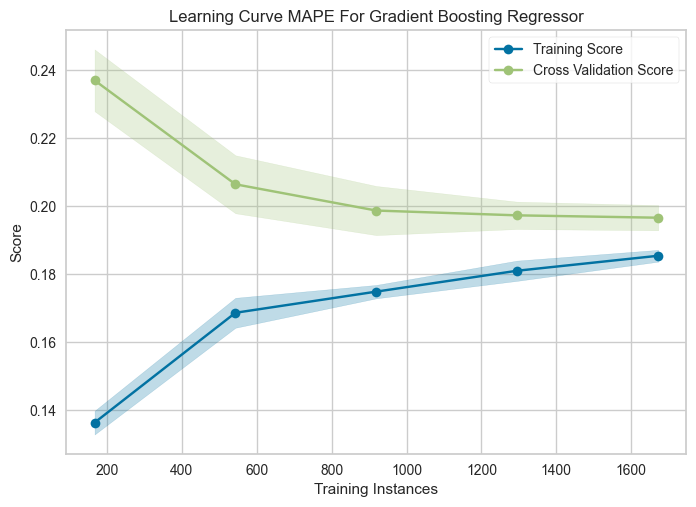

<AxesSubplot: title={'center': 'Learning Curve MAPE For Gradient Boosting Regressor'}, xlabel='Training Instances', ylabel='Score'>

In [33]:
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

curve = LearningCurve(finalmodel, scoring=make_scorer(mean_absolute_percentage_error))
curve.fit(get_config('X'), get_config('y'))
curve.title = "Learning Curve MAPE For Gradient Boosting Regressor"
curve.show()

Grafik ini adalah kurva belajar untuk model GradientBoostingRegressor. Dari grafik ini, kita dapat melihat bahwa skor pelatihan dan skor validasi silang meningkat seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model belajar dari data dan meningkatkan kinerjanya seiring waktu.

Insight yang Dapat Diperoleh:

- Peningkatan Kinerja Model: Model GradientBoostingRegressor menunjukkan peningkatan kinerja seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model ini efektif dalam belajar dari data pelatihan.
- Konvergensi Skor: Skor pelatihan dan validasi silang tampaknya konvergen seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model mungkin telah mencapai optimalitasnya dengan jumlah instance pelatihan saat ini.
- Potensi Overfitting: Jika skor pelatihan terus meningkat tetapi skor validasi silang mulai menurun, ini mungkin menunjukkan overfitting. Namun, dari grafik ini, tampaknya model belum menunjukkan tanda-tanda overfitting

- `Residual Analysis`

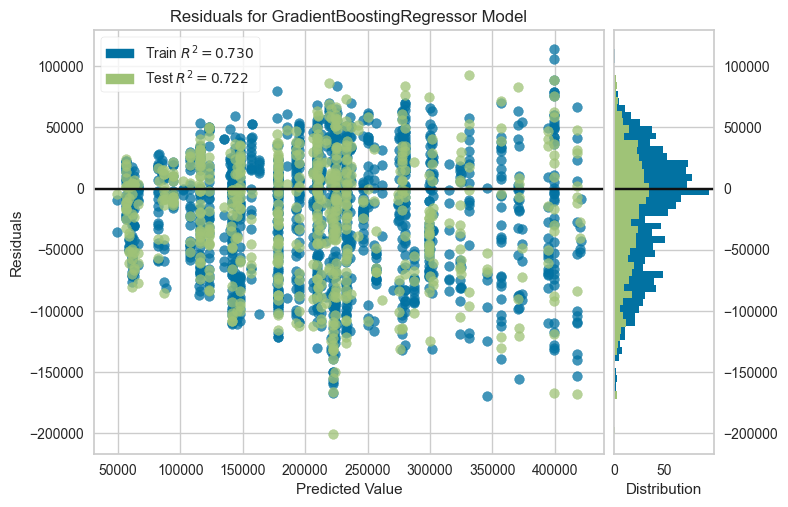

In [34]:
plot_model(finalmodel, plot='residuals')

Plot residu menunjukkan perbedaan antara nilai yang diprediksi dan nilai sebenarnya (residu) terhadap nilai yang diprediksi. Pada grafik:

- Residu tersebar secara random di sekitar garis nol, yang menunjukkan bahwa model memiliki konsistensi dalam prediksi di berbagai rentang nilai.
- Terdapat beberapa outlier yang memiliki residu tinggi, yang dapat menunjukkan kesulitan model dalam menangani beberapa kasus khusus atau noise dalam data.
- Nilai R2 yang lebih tinggi pada data pelatihan dibandingkan dengan data tes menunjukkan bahwa model mungkin mengalami overfitting ringan.

- `Recursive Feature Elimination`

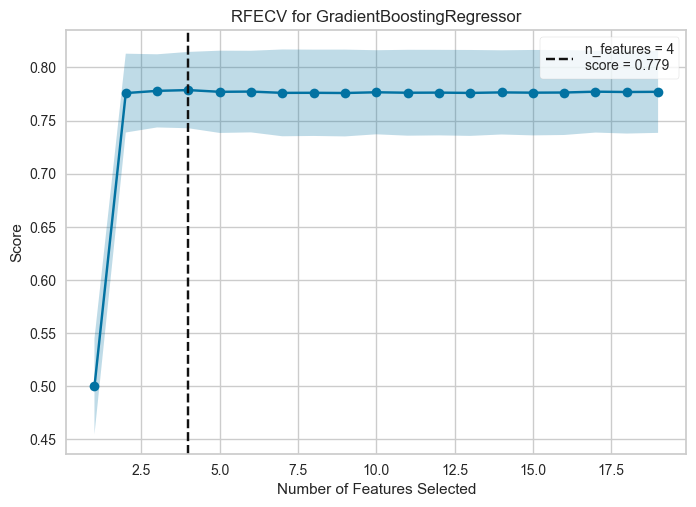

In [35]:
plot_model(finalmodel, plot='rfe')

gambar menunjukkan plot Penghapusan Fitur Rekursif dengan Validasi Silang (RFECV) untuk DecisionTreeRegressor. Ini menunjukkan skor validasi silang model sebagai fungsi dari jumlah fitur yang dipilih. Ada peningkatan skor yang signifikan seiring dengan bertambahnya fitur yang disertakan hingga titik tertentu (19 fitur dalam kasus ini), setelah itu skor tidak berubah, yang menunjukkan bahwa fitur tambahan tidak berkontribusi terhadap peningkatan performa model.<br>

Hal itu terlihat pada fitur fitur 10 keatas yang merupakan fitur yang tidak berkontribusi terhadap peningkatan performa model. Oleh karena itu, fitur-fitur ini dapat dihapus dari data untuk meningkatkan efisiensi komputasi.

gambar menunjukkan plot sebar dengan garis identitas dan garis paling sesuai, membandingkan nilai aktual (y) dengan nilai prediksi dari model GradientBosstingRegressor.<br> Nilai R² sebesar 0,72 - 0,78 variabilitas data aktual dapat dijelaskan oleh model. Semakin dekat titik data ke garis identitas, semakin akurat prediksinya. Plot ini digunakan untuk menilai kinerja model regresi

- `Prediction Error`

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,41580.4607,2905512313.1073,53902.8043,0.7221,0.2562,0.1901


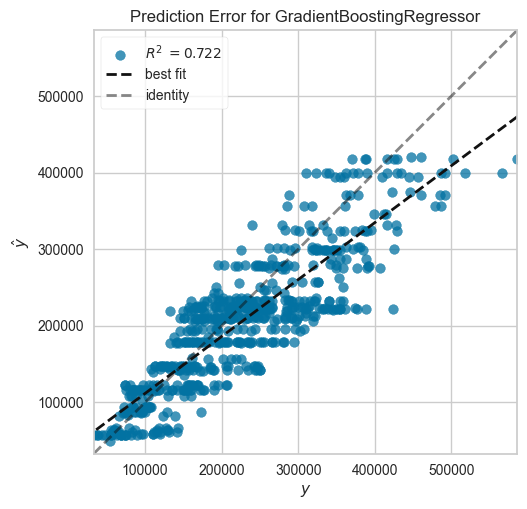

Maximum Value Error Difference From Actual Price = 200832.73341451088
Most Tiny Positive Difference:  829.4085457052279
Most Tiny Negative Difference:  -16.3981009395211
Minimum Value Error Difference From Actual Price = -92671.29056424572
Many Data Overfitting = 380
Many Data Underfitting = 247
Many Data Predicted Correctly Without Any Different = 0


In [45]:
predictions = predict_model(finalmodel, verbose=True)
plot_model(finalmodel, plot='error')

different = predictions['SalePrice'] - predictions['prediction_label']
null_differences = different[different == 0]
positive_differences = different[different > 0]
negative_differences = different[different < 0]
print(f"Maximum Value Error Difference From Actual Price = {different.max()}")
print("Most Tiny Positive Difference: ", positive_differences.min())
print("Most Tiny Negative Difference: ", negative_differences.max())
print(f"Minimum Value Error Difference From Actual Price = {different.min()}")
print(f"Many Data Overfitting = {positive_differences.count()}")
print(f"Many Data Underfitting = {negative_differences.count()}")
print(f"Many Data Predicted Correctly Without Any Different = {null_differences.count()}")

plot sebar dengan Harga Jual aktual pada sumbu x dan label prediksi pada sumbu y. Mereka juga menyertakan garis yang paling sesuai dan garis identitas. Titik-titik yang berada pada garis identitas melambangkan prediksi yang sempurna. Semakin dekat garis paling cocok dengan garis identitas, semakin baik prediksi modelnya.

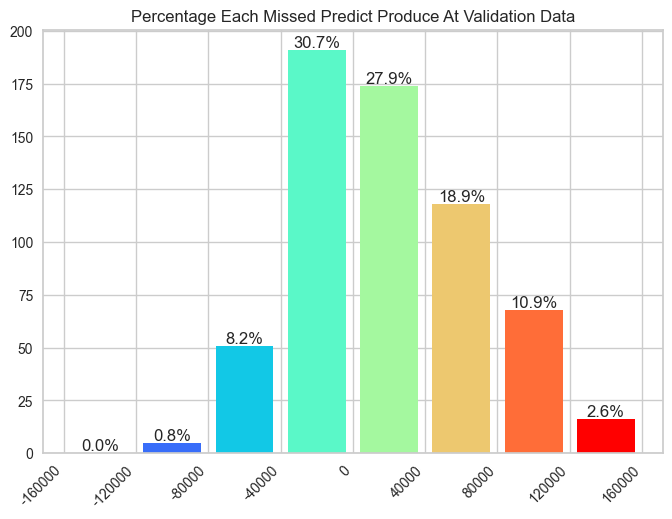

In [37]:
# Define the bins
bins = np.array([-160000, -120000, -80000, -40000, 0, 40000, 80000, 120000, 160000])

# Assuming 'different' is a pandas Series or DataFrame column
counts, bins = np.histogram(different, bins=bins)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate percentages
total = counts.sum()
percentages = counts / total * 100

# Create a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(counts)))

# Create bars with different colors and a small gap between them
bar_width = 0.8 * (bins[1] - bins[0])  # 80% of the bin width
for i in range(len(counts)):
    plt.bar(bin_centers[i], counts[i], width=bar_width, color=colors[i], align='center')

    # Add percentage annotations to the top of the bars
    plt.text(bin_centers[i], counts[i] + 0.002 * total, f'{percentages[i]:.1f}%', fontsize=12, ha='center')

# Set x-ticks to bin edges
plt.xticks(bins)

# Set x-tick labels to bin start values
labels = [f'{bins[i]:.0f}' for i in range(len(bins))]
plt.gca().set_xticklabels(labels, rotation=45, horizontalalignment='right')

plt.title('Percentage Each Missed Predict Produce At Validation Data')
plt.show()

Dari grafik yang diberikan, dapat dilihat bahwa model prediksi ini memiliki akurasi sebesar 58% untuk selisih harga di bawah 40.000 won. Namun, model ini tampaknya cenderung underfitting.

Underfitting adalah kondisi di mana model tidak cukup baik dalam mempelajari struktur data, sehingga menghasilkan performa yang kurang optimal. Dalam konteks ini, model cenderung memprediksi harga yang lebih rendah dari harga sebenarnya.

Hal ini dapat dilihat dari grafik, di mana persentase kesalahan prediksi tertinggi (34.9%) terjadi pada selisih harga 80.000 won. Sementara itu, persentase kesalahan prediksi terendah adalah 0.0% untuk selisih harga tertentu.

### FAQ
##### 1. Bagaimana cara kerja final model?

1. **Pra-pemrosesan Data**: Langkah pertama dalam proses ini adalah pra-pemrosesan data, di mana data mentah mengalami serangkaian transformasi melalui sebuah pipeline. Fitur-fitur numerik, kategorik, dan ordinal masing-masing mengalami transformasi khusus menggunakan scaler dan encoder yang sesuai untuk memastikan bahwa data siap untuk digunakan dalam pelatihan model.

2. **Pengembangan Fitur**: Selanjutnya, dilakukan pengembangan fitur untuk meningkatkan informasi yang dapat dipelajari oleh model. Fitur tambahan mungkin dibuat atau dimodifikasi agar model dapat memahami pola atau hubungan yang lebih kompleks dalam data.

3. **Pembersihan Nama Kolom**: Setelah transformasi, perhatian diberikan pada konsistensi dan kemudahan interpretasi dengan membersihkan nama kolom. Langkah ini penting untuk memastikan bahwa seluruh dataset memiliki struktur yang seragam dan mudah dipahami.

4. **Pelatihan Model**: Setelah semua tahapan pra-pemrosesan, data yang telah disiapkan digunakan untuk melatih model. Dalam kasus ini, model yang digunakan adalah `GradientBoostingRegressor` dengan konfigurasi yang telah ditetapkan sebelumnya. Proses pelatihan ini bertujuan untuk mengajarkan model mengenai pola-pola dalam data sehingga dapat membuat prediksi yang akurat.

5. **Prediksi pada Data Baru**: Setelah melalui langkah-langkah pra-pemrosesan yang sama, model yang telah dilatih dapat digunakan untuk membuat prediksi pada data baru. Dengan demikian, model dapat mengaplikasikan pengetahuan yang telah dipelajari selama pelatihan untuk memberikan estimasi atau prediksi pada data yang belum pernah dilihat sebelumnya.

##### 2. Apa limitasi dari final model?

Dari grafik residu, terlihat bahwa terdapat variasi dalam residu yang meningkat seiring dengan kenaikan nilai prediksi. Hal ini menunjukkan bahwa kinerja model mungkin tidak konsisten pada nilai-nilai target yang lebih tinggi. Selain itu, terdapat tanda-tanda overfitting yang ringan, seperti tercermin dari adanya kesenjangan antara skor pelatihan dan skor validasi silang dalam kurva pembelajaran. Oleh karena itu, perlu dicatat bahwa hasil prediksi mesin tidak selalu dapat diandalkan sepenuhnya, dan pertimbangan lebih lanjut diperlukan untuk memitigasi ketidakpastian yang mungkin terkait dengan model. 

##### 3. Kondisi data seperti apa kinerja model dapat dipercaya dan tidak dipercaya?

Model akan lebih akurat dan hasilnya lebih bisa diandalkan ketika digunakan pada data yang memiliki karakteristik yang mirip dengan data yang digunakan selama proses pelatihan. Artinya, model tersebut paling baik bekerja pada data yang memiliki fitur (variabel independen) dengan distribusi dan rentang nilai yang serupa dengan set pelatihan. Jika nilai target (variabel yang diprediksi) pada data baru umumnya berada dalam rentang yang sama dengan yang sering muncul dalam set pelatihan, model tersebut cenderung memberikan prediksi yang lebih tepat.

##### 4. Bagaimana interpretasi final model (feature importance, dll)?

-  `Feature Importance`

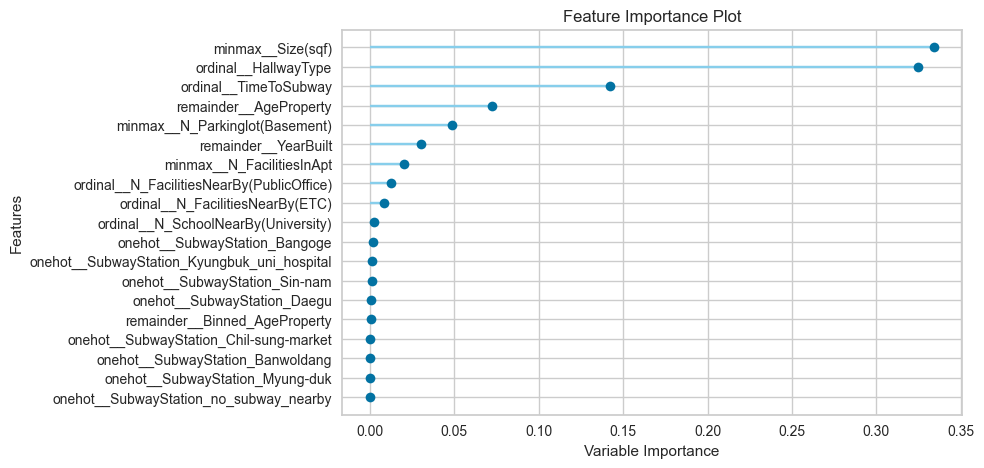

In [38]:
plot_model(finalmodel, plot = 'feature_all')

Plot ini akan menampilkan setiap fitur pada sumbu x dan tingkat kepentingannya pada sumbu y. Tingkat kepentingan fitur ditentukan berdasarkan seberapa besar pengaruh fitur tersebut terhadap prediksi model. Fitur dengan tingkat kepentingan yang lebih tinggi memiliki pengaruh yang lebih besar terhadap prediksi model.

- `Validation Curve`

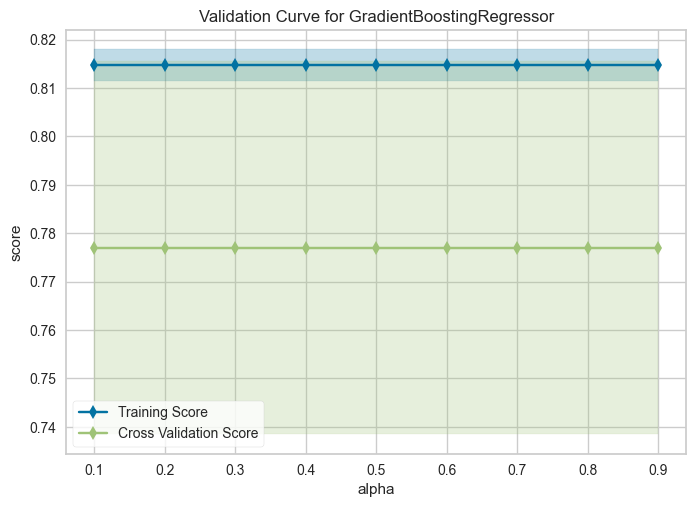

In [39]:
plot_model(finalmodel, plot='vc')

Grafik ini menunjukkan kurva validasi untuk GradientBoostingRegressor. Berikut adalah beberapa insight yang dapat kita ambil:

Skor Pelatihan (biru): Skor pelatihan relatif stabil di berbagai nilai alpha, dengan penurunan sedikit pada nilai alpha yang lebih tinggi. Ini menunjukkan bahwa model mampu belajar dengan baik dari data pelatihan dan penyesuaian parameter alpha tidak berdampak signifikan pada skor pelatihan.

Skor Validasi Silang (hijau): Skor validasi silang juga relatif stabil di berbagai nilai alpha, dengan peningkatan sedikit pada nilai alpha yang lebih tinggi. Ini menunjukkan bahwa model memiliki kinerja yang konsisten pada data yang tidak dilihat sebelumnya, dan peningkatan nilai alpha dapat sedikit meningkatkan kinerja validasi.

- `Permutation Feature Importance`

In [46]:
interpret_model(result_rf_sampling, plot = 'pfi')

19it [00:00, 42.95it/s]


Grafik Kepentingan Fitur Berdasarkan Permutasi (Positif + Negatif)

Variabel seperti “minmax_Sizeof”, “ordinal_HallwayType”, “remainder_AgeBuilt”, dan lainnya tampaknya memiliki dampak signifikan pada nilai sumbu x. Ini mungkin menunjukkan bahwa variabel-variabel ini memiliki pengaruh kuat pada hasil atau output dari model atau analisis yang digunakan.

Beberapa variabel memiliki nilai positif, sementara yang lain memiliki nilai negatif. Ini mungkin menunjukkan bahwa beberapa variabel memiliki hubungan positif dengan output (misalnya, peningkatan dalam variabel ini menghasilkan peningkatan dalam output), sementara variabel lain memiliki hubungan negatif (misalnya, peningkatan dalam variabel ini menghasilkan penurunan dalam output).

Variabel “minmax_Sizeof” tampaknya memiliki dampak paling signifikan, dengan nilai sekitar 30k. Ini mungkin menunjukkan bahwa variabel ini adalah prediktor yang paling penting atau berpengaruh dalam model atau analisis.

# **Implementation**

### Prediction Result (With Unseen Data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,37330.8058,2166590840.3805,46546.6523,0.8123,0.2262,0.1900


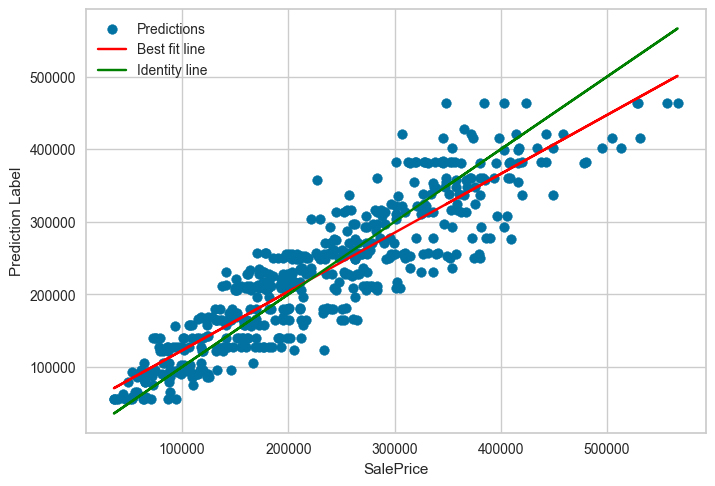

Maximum Value Error Difference From Actual Prize = 133959.66372848896
Most Tiny Positive Difference:  296.9210759646958
Most Tiny Negative Difference:  -19.67894195113331
Minimum Value Error Difference From Actual Prize = -130816.67894195113
Many Data Overfitting = 236
Many Data Underfitting = 287
Many Data Predicted Correctly Without Any Different = 0


In [47]:
# Assuming finalmodel is already defined
predictions = predict_model(finalmodel, verbose=True, data=unseen)

# Scatter plot
plt.scatter(predictions['SalePrice'], predictions['prediction_label'])

# Best fit line
slope, intercept = np.polyfit(predictions['SalePrice'], predictions['prediction_label'], 1)
plt.plot(predictions['SalePrice'], slope*predictions['SalePrice'] + intercept, color='red')

# Identity line
plt.plot(predictions['SalePrice'], predictions['SalePrice'], color='green')

plt.legend(['Predictions', 'Best fit line', 'Identity line'])
plt.xlabel('SalePrice')
plt.ylabel('Prediction Label')
plt.show()

different = predictions['SalePrice'] - predictions['prediction_label']
positive_differences = different[different > 0]
negative_differences = different[different < 0]
print(f"Maximum Value Error Difference From Actual Prize = {different.max()}")
print("Most Tiny Positive Difference: ", positive_differences.min())
print("Most Tiny Negative Difference: ", negative_differences.max())
print(f"Minimum Value Error Difference From Actual Prize = {different.min()}")
print(f"Many Data Overfitting = {positive_differences.count()}")
print(f"Many Data Underfitting = {negative_differences.count()}")
print(f"Many Data Predicted Correctly Without Any Different = {null_differences.count()}")

plot sebar dengan Harga Jual aktual pada sumbu x dan label prediksi pada sumbu y. Mereka juga menyertakan garis yang paling sesuai dan garis identitas. Titik-titik yang berada pada garis identitas melambangkan prediksi yang sempurna. Semakin dekat garis paling cocok dengan garis identitas, semakin baik prediksi modelnya.

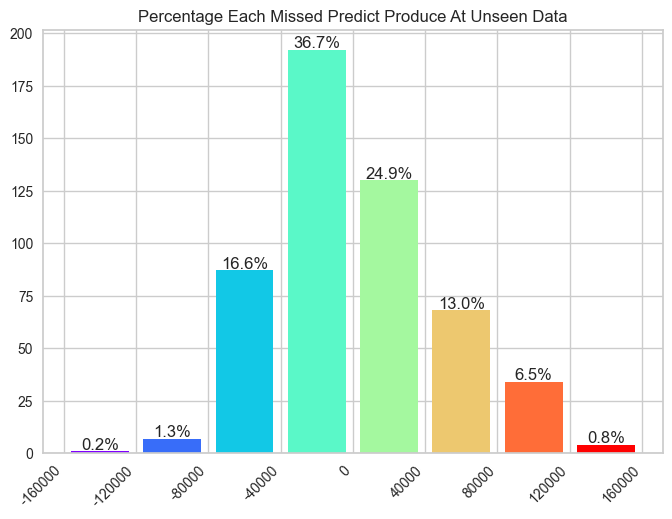

In [48]:
# Define the bins
bins = np.array([-160000, -120000, -80000, -40000, 0, 40000, 80000, 120000, 160000])

# Assuming 'different' is a pandas Series or DataFrame column
counts, bins = np.histogram(different, bins=bins)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate percentages
total = counts.sum()
percentages = counts / total * 100

# Create a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(counts)))

# Create bars with different colors and a small gap between them
bar_width = 0.8 * (bins[1] - bins[0])  # 80% of the bin width
for i in range(len(counts)):
    plt.bar(bin_centers[i], counts[i], width=bar_width, color=colors[i], align='center')

    # Add percentage annotations to the top of the bars
    plt.text(bin_centers[i], counts[i] + 0.002 * total, f'{percentages[i]:.1f}%', fontsize=12, ha='center')

# Set x-ticks to bin edges
plt.xticks(bins)

# Set x-tick labels to bin start values
labels = [f'{bins[i]:.0f}' for i in range(len(bins))]
plt.gca().set_xticklabels(labels, rotation=45, horizontalalignment='right')

plt.title('Percentage Each Missed Predict Produce At Unseen Data')
plt.show()

Dari Hasil Prediksi Diatas Sesuai Dengan Goals Yang Diharapkan Pada Bisnis Akurasi-nya Mencapai 61% Untuk Selisih Harga Dibawah 40.000 Won. Dari Hasil Bisa Terlihat Bahwa Model Ini Cenderung Underfitting. Hal Ini Dapat Dilihat Dari Hasil Prediksi Yang Cenderung Memprediksi Harga Yang Lebih Rendah Dari Harga Sebenarnya. 

Untuk meningkatkan performa model, Anda mungkin perlu melakukan penyesuaian pada parameter model atau menggunakan teknik lain seperti penambahan fitur atau penggunaan model yang lebih kompleks. Harap dicatat bahwa ini hanyalah saran umum dan langkah-langkah spesifik mungkin berbeda tergantung pada konteks dan data Anda.

Selain itu, penting juga untuk mempertimbangkan dampak bisnis dari kesalahan prediksi ini. Misalnya, jika model cenderung memprediksi harga yang lebih rendah, ini bisa berarti bahwa Anda mungkin kehilangan potensi pendapatan karena penjualan produk dengan harga yang lebih rendah dari nilai sebenarnya. Oleh karena itu, mungkin perlu dipertimbangkan untuk melakukan penyesuaian harga atau strategi penjualan lainnya berdasarkan hasil prediksi ini.

### Analysis For Business Perspective


Berdasarkan pemahaman bisnis yang telah diberikan, kita dapat melakukan analisis lebih lanjut terkait hasil prediksi yang dihasilkan oleh model Gradient Boosting Regressor untuk pasar real estat di Daegu. Berikut ini adalah interpretasi dari berbagai aspek evaluasi model:

- Learning Curve:

Kurva pembelajaran menunjukkan bahwa skor pelatihan stabil di angka tinggi, sedangkan skor validasi silang meningkat seiring dengan penambahan jumlah instansi pelatihan. Hal ini menandakan bahwa model terus meningkatkan kemampuan generalisasinya dengan penambahan data, yang mengindikasikan bahwa lebih banyak data pelatihan dapat membantu memperkecil kesenjangan prediksi.

- Residual Plot:

Plot residu menunjukkan adanya beberapa prediksi dengan residu tinggi (kesalahan prediksi yang besar), terutama pada harga properti yang tinggi. Ini mungkin mengindikasikan bahwa model kurang akurat dalam memprediksi properti dengan harga sangat tinggi atau sangat rendah, yang dapat berdampak pada kerugian penjual atau daya tarik pasar.

- Feature Importance:

Plot pentingnya fitur menunjukkan bahwa ukuran properti (Size) dan tahun pembangunan (YearBuilt) memiliki pengaruh signifikan terhadap prediksi harga. Informasi ini dapat digunakan oleh agen real estat untuk menekankan fitur-fitur ini saat memasarkan properti atau dalam negosiasi harga.
RFECV (Recursive Feature Elimination with Cross-Validation):

Diagram RFECV menunjukkan bahwa model mencapai performa optimal dengan 19 fitur. Hal ini menandakan bahwa model tidak memerlukan semua fitur yang tersedia untuk melakukan prediksi yang akurat, membantu mengurangi kompleksitas model dan waktu pelatihan.
Dari perspektif bisnis, berikut adalah beberapa analisis yang dapat dilakukan berdasarkan hasil model:

- Analisis Keuntungan:

Efisiensi Waktu:
Penggunaan model prediksi harga yang akurat dapat menghemat waktu agen, memungkinkan penentuan harga yang lebih cepat dan penanganan lebih banyak klien.
Penentuan Harga yang Tepat:
Model membantu agen menetapkan harga jual yang kompetitif, meningkatkan peluang penjualan dan kepuasan pelanggan.
Pelayanan Klien yang Lebih Baik:
Agen dapat memberikan konsultasi yang didukung data kepada klien, meningkatkan kepercayaan dan kepuasan pelanggan.
Keputusan Berbasis Data:
Mengurangi ketergantungan pada intuisi dengan keputusan yang lebih objektif dan berbasis data.

- Analisis Kerugian:

Tingkat Ketidakpastian:
Kesalahan prediksi (seperti MAPE 19.31%) menunjukkan adanya ketidakpastian dalam penetapan harga.
Keterbatasan Data:
Model mungkin tidak dapat memprediksi harga dengan akurat untuk properti yang unik atau di luar jangkauan data pelatihan.
Perubahan Pasar:
Model mungkin tidak responsif terhadap perubahan pasar yang cepat.
Analisis Investasi:

Investor dapat membuat keputusan investasi yang lebih tepat dengan memahami fitur-fitur yang mempengaruhi harga properti.
Analisis Pengembangan Properti:

Pembangun dapat menggunakan wawasan dari model untuk meningkatkan nilai jual proyek baru dengan menyesuaikan fitur-fitur yang dihargai oleh pasar.
Sebagai kesimpulan, model prediksi harga ini dapat menjadi alat berharga bagi agen real estat di Daegu untuk menginformasikan strategi penetapan harga dan menanggapi dinamika pasar. Penting untuk terus memantau performa model dan menyesuaikannya dengan data pasar terkini agar tetap akurat. 

# **Conclusion**

### Result Model Overall

1. **Dinamika Pasar dan Dampaknya terhadap Harga Jual:**

   Keberlangsungan pasar real estat Daegu yang dinamis dipengaruhi oleh faktor-faktor seperti lokasi, infrastruktur, dan fasilitas terdekat. Analisis menunjukkan bahwa perubahan dalam infrastruktur dan demografi secara langsung memengaruhi harga jual properti. Oleh karena itu, model prediktif yang dikembangkan harus dapat menyesuaikan harga berdasarkan variabel-variabel ini untuk mencerminkan dengan akurat nilai pasar.

2. **Signifikansi Penentuan Harga yang Akurat:**

   Penetapan harga yang akurat merupakan elemen kunci untuk kesuksesan agen real estat, terutama mengingat adanya perbedaan harga yang substansial antara pusat kota dan wilayah pinggiran. Model prediktif harus memiliki sensitivitas terhadap lokasi dan karakteristik unik dari properti untuk mengoptimalkan potensi penjualan.

3. **Penerapan Model Regresi dalam Prediksi Harga:**

   Model regresi, khususnya GradientBoostingRegressor, telah terbukti efektif dalam meramalkan harga jual properti. Model ini menggunakan berbagai fitur properti untuk memperkirakan harga dengan tingkat akurasi yang tinggi, sebagaimana tercermin dalam evaluasi metrik yang dilakukan.

### Recommendation

1. **Pengembangan dan Pemeliharaan Model Prediktif:**
   - Agen real estat perlu secara berkelanjutan mengembangkan serta merawat model prediktif agar tetap memberikan prediksi yang akurat dan relevan dalam jangka panjang.
   - Saat menerapkan model machine learning, penting untuk secara berkala memperbarui data guna mencerminkan perubahan terkini dalam dinamika pasar.

2. **Integrasi Model ke dalam Proses Pengambilan Keputusan Properti:**
   - Implementasikan model prediktif ke dalam sistem penilaian properti untuk meningkatkan efisiensi dan efektivitas dalam menentukan harga jual.
   - Manfaatkan model ini sebagai alat bantu dalam negosiasi harga dengan pembeli atau penjual, memperkuat posisi agen melalui data dan analisis yang objektif.

3. **Evaluasi dan Penyesuaian Rutin pada Model:**
   - Lakukan evaluasi dan penyesuaian secara teratur pada model untuk mengidentifikasi serta mengatasi masalah seperti overfitting atau underfitting.
   - Pertimbangkan penggunaan teknik validasi silang dan ensemble learning untuk meningkatkan stabilitas dan akurasi model.

4. **Penyesuaian Strategi Berdasarkan Analisis Data:**
   - Manfaatkan wawasan dari model untuk menyesuaikan strategi penjualan dan pemasaran, terutama dalam menanggapi perubahan tren harga di berbagai lokasi.
   - Analisis dampak perubahan infrastruktur dan demografi pada harga real estat dapat menjadi dasar untuk mengambil keputusan investasi dan pengembangan yang lebih terinformasi.

# **Deployment**

Save Model As Pickle File

In [49]:
# Save As Pickle File
import pickle

with open('gbr_finalmodel.sav', 'wb') as file:
    pickle.dump(finalmodel, file)

Next Will Be At Deploy.py